In [ ]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.nn.utils import spectral_norm
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

import time
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"
torch.set_default_dtype(torch.float64)

In [ ]:
class DNN(nn.Module):
    def __init__(self, neurons, activation, spectral=False):

        super(DNN, self).__init__()
        self.activation = activation
        self.n_layers = len(neurons)
        self.dense = {}
        self.nn_layers = nn.ModuleList()

        for i in range(self.n_layers-1):
            self.dense[str(i)] = nn.Linear(neurons[i], neurons[i+1])
            nn.init.xavier_uniform_(self.dense[str(i)].weight)
            nn.init.zeros_(self.dense[str(i)].bias)
            self.nn_layers.append(self.dense[str(i)])
            
    def forward(self, *args):
        x = torch.cat(args,1)
        activation = self.activation
        for i in range(self.n_layers-2):
            x = activation(self.dense[str(i)](x))
        i = self.n_layers-2
        return self.dense[str(i)](x)

In [ ]:
device='cuda'
torch.manual_seed(0)

dim_x = 1
dim_z = 10
B_size=64

u_means = []
u_stds = []

N_test = 20000
m_test = 201
with open('test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)
x_test = torch.tensor(test_data['x'], device=device).T
z_test = torch.randn([N_test,dim_z],device=device)

ref_mean = torch.tensor(test_data['u_mean'])
ref_std = torch.tensor(test_data['u_std'])

In [4]:
p=64
net_size_ux = [B_size,64,64,p]
net_size_uz = [B_size,64,64,p]

def FEx(x):
    x_sin = torch.sin(torch.matmul(x,B_x))
    x_cos = torch.cos(torch.matmul(x,B_x))
    return torch.concat([x_cos,x_sin],-1)

def FEz(x):
    x_sin = torch.sin(torch.matmul(x,B_z))
    x_cos = torch.cos(torch.matmul(x,B_z))
    return torch.concat([x_cos,x_sin],-1)

acti = torch.sin
ux = DNN(net_size_ux, activation=acti).to(device)
uz = DNN(net_size_uz, activation=acti).to(device)

def GU(X, Z):
    X_FE = FEx(X)
    Z = FEz(Z)
    outx = acti(ux(X_FE))*(X-1)*(X+1)
    outz = uz(Z)
    out = torch.matmul(outz,outx.T)
    return out

save_path='WGANSN_PCN_SD'
with open(save_path+'/B_x.pickle', 'rb') as f:
    B_x = pickle.load(f)
with open(save_path+'/B_z.pickle', 'rb') as f:
    B_z = pickle.load(f)
ux.load_state_dict(torch.load(save_path+'/paramsux'))
uz.load_state_dict(torch.load(save_path+'/paramsuz'))

with torch.no_grad():
    u_gen = GU(x_test, z_test).cpu()
    u_means.append(u_gen.mean(0))
    u_stds.append(u_gen.std(0))
    
save_path='WGANSN_PCN_MD'
with open(save_path+'/B_x.pickle', 'rb') as f:
    B_x = pickle.load(f)
with open(save_path+'/B_z.pickle', 'rb') as f:
    B_z = pickle.load(f)
ux.load_state_dict(torch.load(save_path+'/paramsux'))
uz.load_state_dict(torch.load(save_path+'/paramsuz'))

with torch.no_grad():
    u_gen = GU(x_test, z_test).cpu()
    u_means.append(u_gen.mean(0))
    u_stds.append(u_gen.std(0))

In [5]:
net_size_u = [B_size+dim_z,64,64,1]

def FEx(x):
    x_sin = torch.sin(torch.matmul(x,B_x))
    x_cos = torch.cos(torch.matmul(x,B_x))
    return torch.concat([x_cos,x_sin],-1)

acti = torch.sin
un = DNN(net_size_u, activation=acti).to(device)

def GU(X, Z):
    xsize=X.shape[0]
    zsize=Z.shape[0]
    X = X.repeat([zsize,1]).reshape(-1,dim_x)
    Z = Z.repeat([1,xsize]).reshape(-1,dim_z)
    
    X_FE = FEx(X)
    out = un(X_FE, Z)*(X-1)*(X+1)

    return out.reshape(zsize,xsize)


save_path='WGANSN_FCN_SD'
with open(save_path+'/B_x.pickle', 'rb') as f:
    B_x = pickle.load(f)
un.load_state_dict(torch.load(save_path+'/paramsu'))

with torch.no_grad():
    u_gen = GU(x_test, z_test).cpu()
    u_means.append(u_gen.mean(0))
    u_stds.append(u_gen.std(0))
    
save_path='WGANSN_FCN_MD'
with open(save_path+'/B_x.pickle', 'rb') as f:
    B_x = pickle.load(f)
un.load_state_dict(torch.load(save_path+'/paramsu'))

with torch.no_grad():
    u_gen = GU(x_test, z_test).cpu()
    u_means.append(u_gen.mean(0))
    u_stds.append(u_gen.std(0))

In [6]:
colors_ = [plt.cm.Paired(i) for i in range(20)]
x_test_ = x_test.flatten().cpu()

color_ref = 'k'
colors = [colors_[1],colors_[5],colors_[8],colors_[14]]
labels = ['PCN_SD','PCN_MD','FCN_SD','FCN_MD']
linetypes = ['--', ':','--',':']

In [7]:
L =len(u_means)
er_means = []
er_stds = []
for i in range(L):
    print(labels[i])
    er_means.append(torch.norm(u_means[i]-ref_mean)/torch.norm(ref_mean))
    er_stds.append(torch.norm(u_stds[i]-ref_std)/torch.norm(ref_std))

PCN_SD
PCN_MD
FCN_SD
FCN_MD


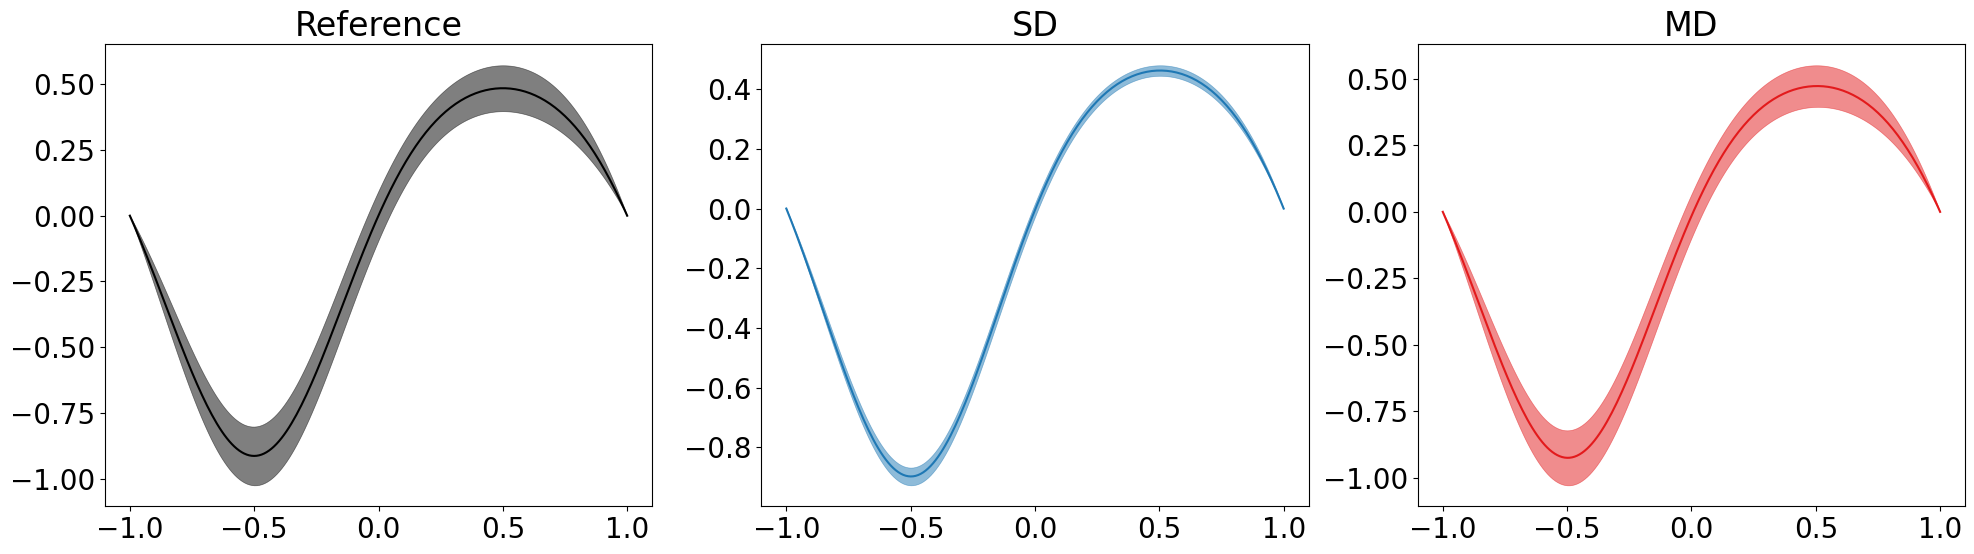

In [8]:
fig = plt.figure(figsize=(24,6))
axes = [plt.subplot(1,3,1), plt.subplot(1,3,2), plt.subplot(1,3,3)]

for i in range(2):
    axes[i+1].plot(x_test_,u_means[i],'-',label=labels[i], color=colors[i])
    axes[i+1].fill_between(x_test_, u_means[i]+u_stds[i], u_means[i]-u_stds[i], alpha=0.5, linewidth=.5, color=colors[i])
    # axes[i+1].legend(fontsize="15")
    
axes[0].plot(x_test_.flatten(),ref_mean, '-',label='exact', color=color_ref)
axes[0].fill_between(x_test_, ref_mean+ref_std, ref_mean-ref_std, alpha=0.5, linewidth=.5, color=color_ref)
# axes[0].legend(fontsize="15")

axes[0].set_title('Reference')
axes[1].set_title('SD')
axes[2].set_title('MD')

fig.show()
fig.savefig('images/Elliptic_meanstd.pdf',bbox_inches='tight')


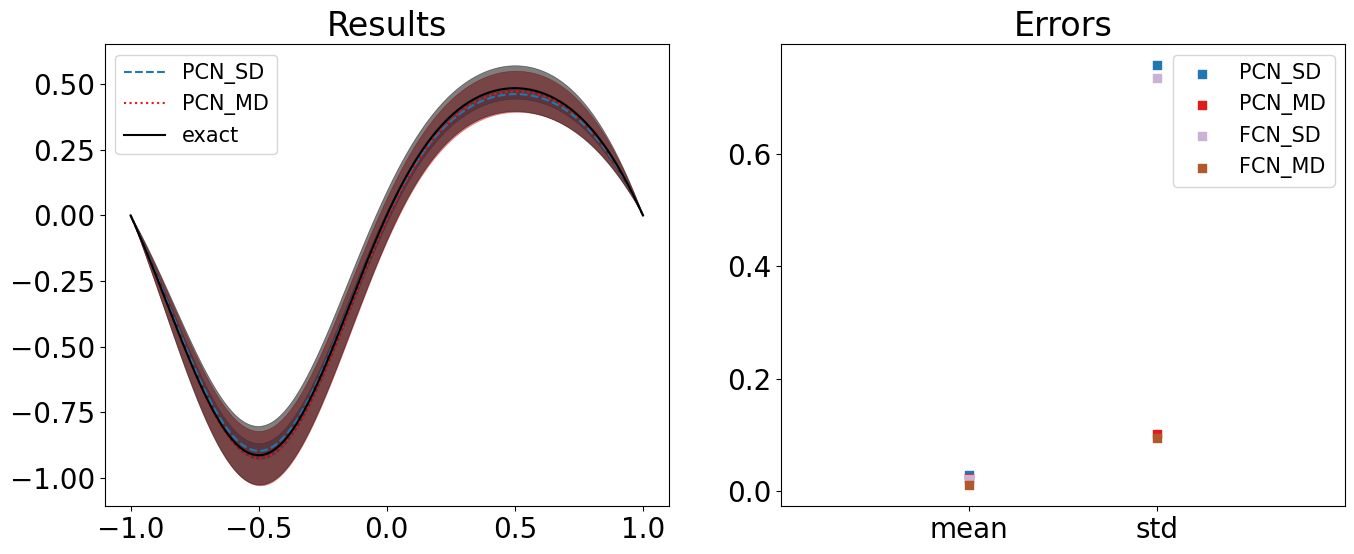

In [9]:
fig = plt.figure(figsize=(16,6))
axes = [plt.subplot(1,2,1), plt.subplot(1,2,2)]

for i in range(2):
    axes[0].plot(x_test_,u_means[i],linetypes[i],label=labels[i], color=colors[i])
    axes[0].fill_between(x_test_, u_means[i]+u_stds[i], u_means[i]-u_stds[i], alpha=0.5, linewidth=.5, color=colors[i])

axes[0].plot(x_test_.flatten(),ref_mean, '-',label='exact', color=color_ref)
axes[0].fill_between(x_test_, ref_mean+ref_std, ref_mean-ref_std, alpha=0.5, linewidth=.5, color=color_ref)
axes[0].legend(fontsize="15")
axes[0].set_title('Results')

for i in range(L):
    axes[1].scatter(0,er_means[i],marker='s',label=labels[i],color=colors[i])
    axes[1].scatter(1,er_stds[i],marker='s',color=colors[i])
axes[1].legend(fontsize="15")
axes[1].set_title('Errors')
axes[1].set_xlim([-1,2])
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['mean','std'])
fig.show()
fig.savefig('images/results.pdf',bbox_inches='tight')


In [24]:
print(er_means)
print(er_stds)

[tensor(0.0287), tensor(0.0230), tensor(0.0225), tensor(0.0108)]
[tensor(0.7577), tensor(0.1017), tensor(0.7357), tensor(0.0958)]


In [ ]:
['PCN_SD','PCN_MD','FCN_SD','FCN_MD']

In [ ]:
!kill -9 {os.getpid()}